# 彼得与狼：真实环境

在我们的场景中，彼得几乎可以不感到疲惫或饥饿地四处移动。在更真实的世界中，他需要时不时地坐下来休息，还需要进食。让我们通过实施以下规则使我们的世界更加真实：

1. 从一个地方移动到另一个地方时，彼得会失去**能量**并增加一些**疲劳**。
2. 彼得可以通过吃苹果来获得更多能量。
3. 彼得可以通过在树下或草地上休息来消除疲劳（即走到棋盘上有树或草的地方——绿色区域）。
4. 彼得需要找到并杀死狼。
5. 为了杀死狼，彼得需要达到一定的能量和疲劳水平，否则他会在战斗中失败。


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

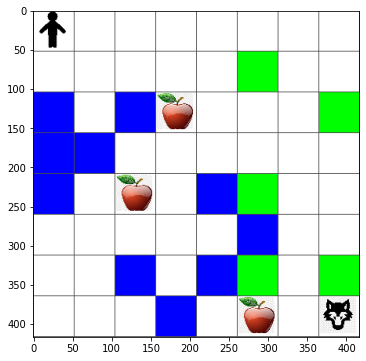

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## 定义状态

在我们的新游戏规则中，我们需要在每个棋盘状态下跟踪能量和疲劳。因此，我们将创建一个对象 `state`，它将包含当前问题状态所需的所有信息，包括棋盘状态、当前的能量和疲劳水平，以及在终端状态下是否能够击败狼：


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

让我们尝试使用随机游走来解决这个问题，看看是否成功：


In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## 奖励函数

### 什么是奖励函数？

奖励函数是强化学习中用于指导代理行为的核心组件。它定义了代理在特定状态或执行某些动作时所获得的奖励。通过奖励函数，代理能够学习如何在环境中采取最佳行动以实现目标。

### 设计奖励函数的原则

设计一个有效的奖励函数需要遵循以下原则：

1. **明确目标**  
   奖励函数应该清晰地反映任务目标。例如，如果目标是让机器人避开障碍物并到达目标位置，那么奖励函数应该鼓励机器人靠近目标，同时惩罚碰撞行为。

2. **避免稀疏奖励**  
   稀疏奖励可能导致学习过程缓慢。尝试提供更频繁的反馈，以帮助代理更快地理解哪些行为是有益的。

3. **平衡短期与长期奖励**  
   奖励函数应该鼓励代理在短期内采取有益的行动，同时考虑长期目标。例如，避免设计只关注即时奖励而忽略长期效果的函数。

4. **防止意外行为**  
   确保奖励函数不会鼓励代理采取意外或不合理的行为。例如，如果奖励函数仅根据速度奖励代理，可能会导致代理忽略安全性。

### 示例奖励函数

以下是一个简单的奖励函数示例：

```python
def reward_function(state, action):
    if state == "goal_reached":
        return 100  # 到达目标位置的高奖励
    elif state == "collision":
        return -50  # 碰撞的惩罚
    else:
        return -1  # 每一步的轻微惩罚以鼓励快速完成任务
```

### 常见问题

#### 奖励函数过于复杂怎么办？

奖励函数不需要过于复杂。一个简单且清晰的奖励函数通常更容易调试和优化。复杂的奖励函数可能会导致代理难以学习正确的行为。

#### 如何处理代理的意外行为？

如果代理表现出意外行为，检查奖励函数是否存在漏洞。例如，代理可能会尝试最大化奖励而采取不合理的行动。通过调整奖励函数，确保它能够正确引导代理行为。

#### 是否需要动态调整奖励函数？

在某些情况下，动态调整奖励函数可能是有益的。例如，随着任务难度增加，可以逐步提高奖励以激励代理持续改进。

### 总结

奖励函数是强化学习中至关重要的一部分。设计一个有效的奖励函数需要明确目标、提供及时反馈，并防止意外行为。通过不断优化奖励函数，可以帮助代理更快地学习并实现目标。


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Q-Learning 算法

实际的学习算法几乎没有变化，我们只是使用 `state` 而不是仅仅使用棋盘位置。


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

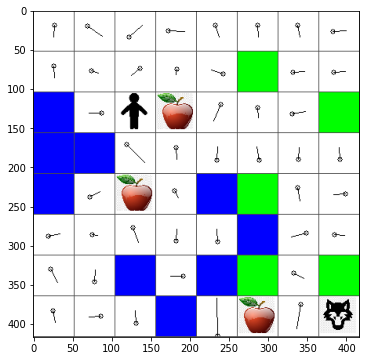

In [11]:
m.plot(Q)

## 结果

让我们看看我们是否成功训练了彼得与狼作战！


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


我们现在看到溺水的案例少了很多，但彼得仍然无法总是杀死狼。尝试进行实验，看看通过调整超参数是否能改善这个结果。


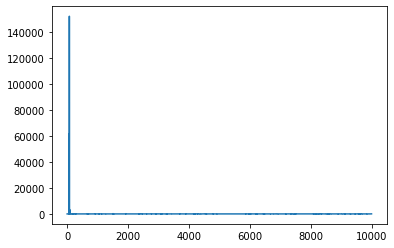

In [13]:
plt.plot(lpath)


---

**免责声明**：  
本文档使用AI翻译服务[Co-op Translator](https://github.com/Azure/co-op-translator)进行翻译。尽管我们努力确保准确性，但请注意，自动翻译可能包含错误或不准确之处。应以原始语言的文档作为权威来源。对于关键信息，建议使用专业人工翻译。因使用本翻译而引起的任何误解或误读，我们概不负责。
